In [1]:
import os,sys,time
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from shutil import copy as cp
from glob import glob
import RealSim_IFS

## Examine some TNG100-1 maps

The gas maps look very strange. Also a problem with camera angles. Different camera angles show the same objects from the same orientation.

/localscratch/bottrell.35054337.0
/home/bottrell/scratch/Merger_Kinematics/LOSVD/TNG100-1/099/kinemetry_datacube_TNG100-1_99_528190_stars_i1.fits
5.395241737365723
/home/bottrell/scratch/Merger_Kinematics/LOSVD/TNG100-1/099/kinemetry_datacube_TNG100-1_99_404216_gas_i0.fits
5.382260322570801
/home/bottrell/scratch/Merger_Kinematics/LOSVD/TNG100-1/099/kinemetry_datacube_TNG100-1_99_403910_stars_i2.fits
4.9026854038238525
/home/bottrell/scratch/Merger_Kinematics/LOSVD/TNG100-1/099/kinemetry_datacube_TNG100-1_99_427314_gas_i1.fits
5.164482116699219


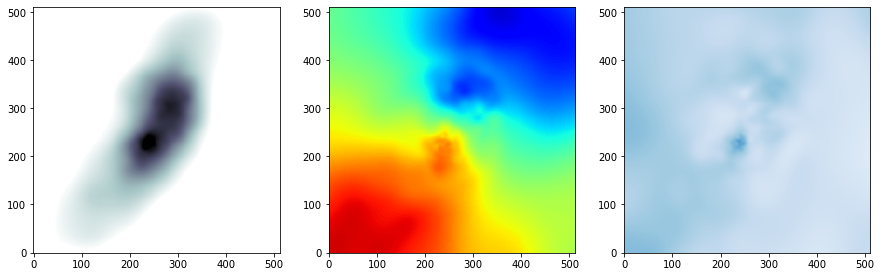

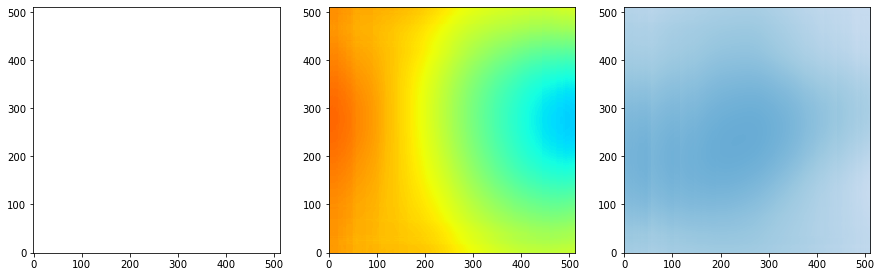

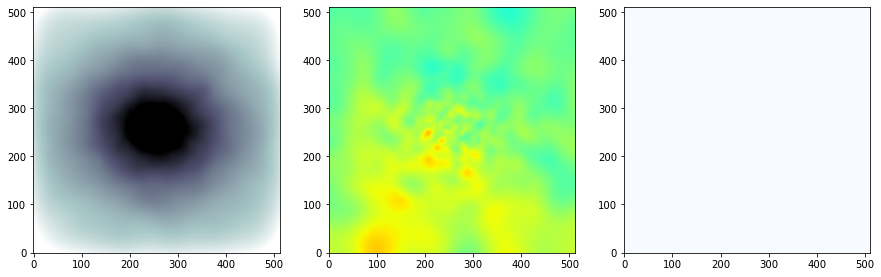

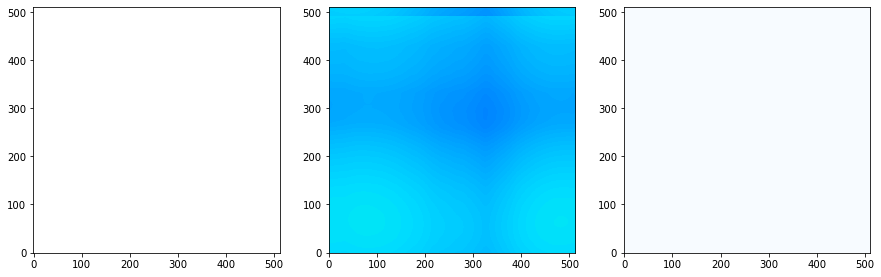

In [4]:
def main():
    
    if 'SLURM_TMPDIR' in [key for key in os.environ.keys()]:
        wdir = os.environ['SLURM_TMPDIR']
        os.chdir(wdir)
        print(os.getcwd())
        
    losvd_dir = '/home/bottrell/scratch/Merger_Kinematics/LOSVD/TNG100-1/099'
    filenames = glob('{}/*.fits'.format(losvd_dir))
    
    
    for filename in filenames[:4]:
        print(filename)
        start = time.time()
        localfile = filename.replace(losvd_dir,wdir)
        start = time.time()
        cp(filename,localfile)
        maps = RealSim_IFS.Generate_Maps_From_File(localfile)
        print(time.time()-start)
        if os.access(localfile,0):os.remove(localfile)
            
        fig,axarr = plt.subplots(1,3,figsize=(15,5))
        ax = axarr[0]
        ax.imshow(np.log10(maps[0]),vmin=4.5,vmax=6,cmap='bone_r',origin='lower')
        ax = axarr[1]
        ax.imshow(maps[1],vmin=-100,vmax=100,cmap='jet_r',origin='lower')
        ax = axarr[2]
        ax.imshow(maps[2],vmin=0,vmax=100,cmap='Blues_r',origin='lower')

#         fig,axarr = plt.subplots(1,3,figsize=(15,5))
#         ax = axarr[0]
#         losvd_head = fits.getheader(filename)
#         losvd_data = fits.getdata(filename)
#         ax.imshow(np.sum(losvd_data,axis=2),cmap='bone_r',origin='lower')
#         print(losvd_data.shape)
#         losvd_shape = losvd_data.shape
#         vlim = losvd_head['VLIM'] # km/s
#         delv = losvd_head['DELV'] # km/s
#         fov = losvd_head['FOVSIZE']/1000. # kpc
#         vel = np.linspace(-vlim,vlim,losvd_shape[-1],endpoint=False)+delv/2.
        
#         fig,ax=plt.subplots(1,1,figsize=(5,5))
#         v = np.linspace(-700,700,300,endpoint=False)+4.6666666666667/2
#         for i in range(512):
#             ax.plot(v,losvd_data[256,i,:])
        
        
    
if __name__ == '__main__':
    main()

## Examine individual cube more closely

Reshape cube to channels first (`Nels`,`spatial_x`,`spatial_y`).

/localscratch/bottrell.36610746.0
4.061860084533691


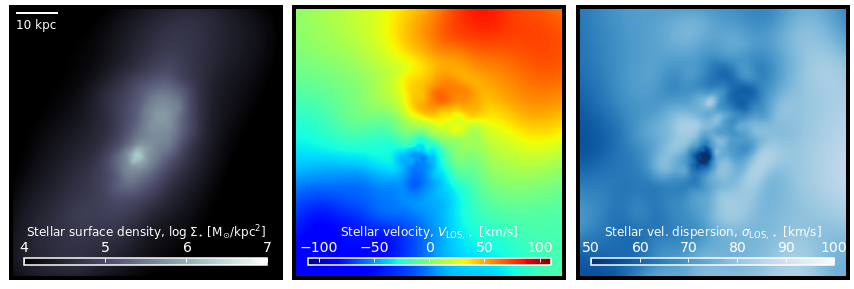

In [36]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import RealSim_IFS
import os,sys,time
from shutil import copy as cp
from copy import copy
    
def add_colorbar(im,ax,label,colour='white'):
    axin = ax.inset_axes(
            [0.05,0.05, 0.9, 0.025], transform=ax.transAxes)
    cbar = plt.colorbar(im, cax=axin, orientation='horizontal')
    cbar.ax.tick_params(color=colour, labelcolor=colour,direction='in',labeltop=1,
                        labelbottom=0,top=1,bottom=0, width=1, labelsize=14)
    cbar.set_label(label, color=colour, size=12)
    cbar.ax.xaxis.set_label_position('top') 
    cbar.outline.set_edgecolor(colour)
    cbar.outline.set_linewidth(1.5)
    
    
def generate_figure(simID,snapID,subhaloID,ptype,camera):
    
    if 'SLURM_TMPDIR' in [key for key in os.environ.keys()]:
        wdir = os.environ['SLURM_TMPDIR']
        os.chdir(wdir)
        print(os.getcwd())
    
    losvd_dir = '/home/bottrell/scratch/Merger_Kinematics/LOSVD/{}/{:03d}'.format(simID,snapID)
    filename = '{}/kinemetry_datacube_{}_{}_{}_{}_{}.fits'.format(losvd_dir,simID,snapID,subhaloID,ptype,camera)
    
    start = time.time()
    localfile = filename.replace(losvd_dir,wdir)
    start = time.time()
    cp(filename,localfile)
    maps = RealSim_IFS.Generate_Maps_From_File(localfile)
    hdr = fits.getheader(localfile)
    print(time.time()-start)
    if os.access(localfile,0):os.remove(localfile)
    
    fig,axarr = plt.subplots(1,3,figsize=(15,5))
    fig.subplots_adjust(wspace=0.05,hspace=0.05)
    axarr = axarr.flat

    for ax in axarr:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        for spine in ['top','left','right','bottom']:
            ax.spines[spine].set_linewidth(4)

    ax = axarr[0]
    cmap = copy(plt.cm.bone)
    cmap.set_bad('black', 1.0)
    im = ax.imshow(np.log10(maps[0]),vmin=4,vmax=7,cmap=cmap,origin='lower',aspect='auto',interpolation=None)
    cbar_colour = 'white'
    label = r'Stellar surface density, $\log\;\Sigma_{\star}$ [M$_{\odot}}$/kpc$^2$]'
    add_colorbar(im,ax,label,colour=cbar_colour)
    
    fov_kpc = hdr['FOV_KPC']
    kpc_per_pixel = fov_kpc/maps.shape[1]
    scale_kpc = 10
    scale_pixels = scale_kpc/kpc_per_pixel
    ax.plot([12,scale_pixels+12],[500,500],lw=2,color='white')
    ax.text(10,490,r'10 kpc',transform=ax.transData,ha='left',va='top',color='white',size=12)

    ax = axarr[1]
    cmap = copy(plt.cm.jet)
    cmap.set_bad('black', 1.0)
    im = ax.imshow(maps[1],vmin=-110,vmax=110,cmap=cmap,origin='lower',aspect='auto',interpolation='none')
    cbar_colour = 'white'
    label = r'Stellar velocity, $V_{\mathrm{LOS},\star}$ [km/s]'
    add_colorbar(im,ax,label,colour=cbar_colour)

    ax = axarr[2]
    cmap = copy(plt.cm.Blues_r)
    cmap.set_bad('black', 1.0)
    im = ax.imshow(maps[2],vmin=50,vmax=100,cmap=cmap,origin='lower',aspect='auto',interpolation=None)
    cbar_colour = 'white'
    label = r'Stellar vel. dispersion, $\sigma_{\mathrm{LOS},\star}$ [km/s]'
    add_colorbar(im,ax,label,colour=cbar_colour)
    
    fig.savefig('/home/bottrell/scratch/Merger_Kinematics/RealSim-IFS/Figures/Idealized_TNG_Kinematics_Test.pdf',bbox_inches='tight')
    
def __main__():
        
    generate_figure('TNG100-1',99,528190,'stars','i0')

if __name__ == '__main__':
        
    __main__()


## Generate fiber array

Plot fiber array overtop of data. The diameters of the fiber are entirely contrived. The fiber positons/diamters are scaled such that they cover the full FOV of the idealized cube. In a real scenario, we would have some scale for converting spatial pixels in the cube to arcsec. This scale can be applied to the fiber positions and diameters.

/localscratch/bottrell.36610746.0
3.8615965843200684


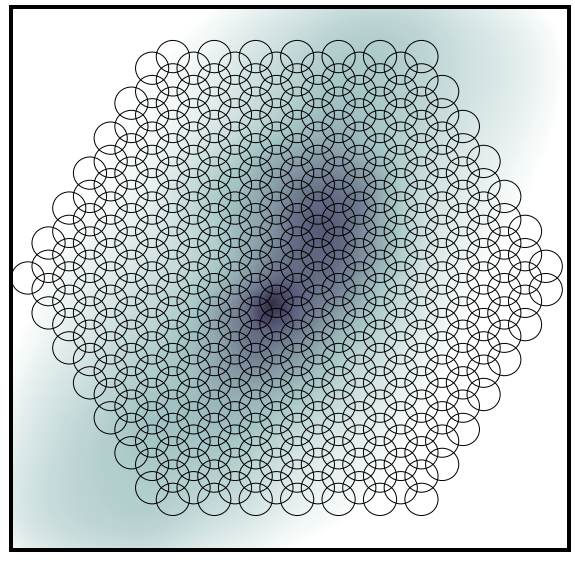

In [20]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import RealSim_IFS
import os,sys,time
from shutil import copy as cp
from copy import copy
from matplotlib.patches import Circle
    
def add_colorbar(im,ax,label,colour='white'):
    axin = ax.inset_axes(
            [0.05,0.05, 0.9, 0.025], transform=ax.transAxes)
    cbar = plt.colorbar(im, cax=axin, orientation='horizontal')
    cbar.ax.tick_params(color=colour, labelcolor=colour,direction='in',labeltop=1,
                        labelbottom=0,top=1,bottom=0, width=1, labelsize=14)
    cbar.set_label(label, color=colour, size=12)
    cbar.ax.xaxis.set_label_position('top') 
    cbar.outline.set_edgecolor(colour)
    cbar.outline.set_linewidth(1.5)  
    
def generate_figure(simID,snapID,subhaloID,ptype,camera):
    
    if 'SLURM_TMPDIR' in [key for key in os.environ.keys()]:
        wdir = os.environ['SLURM_TMPDIR']
        os.chdir(wdir)
        print(os.getcwd())
    
    losvd_dir = '/home/bottrell/scratch/Merger_Kinematics/LOSVD/{}/{:03d}'.format(simID,snapID)
    filename = '{}/kinemetry_datacube_{}_{}_{}_{}_{}.fits'.format(losvd_dir,simID,snapID,subhaloID,ptype,camera)
    
    start = time.time()
    localfile = filename.replace(losvd_dir,wdir)
    start = time.time()
    cp(filename,localfile)
    maps = RealSim_IFS.Generate_Maps_From_File(localfile)
    hdr = fits.getheader(localfile)
    data = fits.getdata(localfile).transpose(2,0,1)
    print(time.time()-start)
    if os.access(localfile,0):os.remove(localfile)
    
    fig,ax = plt.subplots(1,1,figsize=(10,10))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    for spine in ['top','left','right','bottom']:
        ax.spines[spine].set_linewidth(4)
        
    cmap = copy(plt.cm.bone_r)
    cmap.set_bad('black', 1.0)
    im = ax.imshow(np.log10(maps[0]),vmin=4,vmax=7,cmap=cmap,origin='lower',aspect='auto',interpolation=None)
    cbar_colour = 'white'
    #label = r'Stellar surface density, $\log\;\Sigma_{\star}$ [M$_{\odot}}$/kpc$^2$]'
    #add_colorbar(im,ax,label,colour=cbar_colour)
    
    # generate array of fiber positions
    (xc_arr,yc_arr),params = RealSim_IFS.MaNGA_Observe(bundle_name='None',
                                                       fibers_per_side=7,
                                                       n_observations='Classic',
                                                       bundle_xoffset_arcsec=0.,
                                                       bundle_yoffset_arcsec=0.,
                                                       rotation_degrees = 0.,
                                                       return_params=True)
    fiber_diameter_arcsec = params['fiber_diameter_arcsec']
    core_diameter_arcsec = params['core_diameter_arcsec']
    n_observations = xc_arr.shape[-1]

    data_shape = maps.shape

    size_pixels = 2*(np.max(np.abs(xc_arr))+core_diameter_arcsec/2.)
    arcsec_per_pixel = size_pixels/float(data_shape[1])

    # rescale and set new origin
    xc_cores_pixels = xc_arr.flatten()/arcsec_per_pixel+data_shape[1]/2.
    yc_cores_pixels = yc_arr.flatten()/arcsec_per_pixel+data_shape[1]/2.
    diam_cores_pixels = core_diameter_arcsec/arcsec_per_pixel
    diam_fibers_pixels = fiber_diameter_arcsec/arcsec_per_pixel
    
    for xy in zip(xc_cores_pixels,yc_cores_pixels):
#         clad = Circle(xy=xy,radius=diam_fibers_pixels/2,transform=ax.transData,edgecolor='Gray',facecolor='None')
#         ax.add_artist(clad)
        core = Circle(xy=xy,radius=diam_cores_pixels/2,transform=ax.transData,edgecolor='Black',facecolor='None')
        ax.add_artist(core)
        
    fig.savefig('/home/bottrell/scratch/Merger_Kinematics/RealSim-IFS/Figures/TNG_Kinematics_Test_CoreOverlay.pdf',bbox_inches='tight')
        
    return(xc_cores_pixels,yc_cores_pixels,diam_cores_pixels,data,hdr,filename)

if __name__ == '__main__':
        
    xc_cores_pixels,yc_cores_pixels,diam_cores_pixels,data,hdr,filename = generate_figure('TNG100-1',99,528190,'stars','i0')


## Apply fibers to cube and obtain fiber arrays

Issue encountered here. The process is very memory intensive with large numbers of fibers. Calculations are scaling as  `N_fibers` x `spatial_x` x `spatial_y` x `Nels` x 64 b / 8 b/B. For the 512x512x300 cubes, this is 629MB per fiber placed. This is unfeasible and requires a loop to process rather than broadcasting. I have edited the `Fiber_Observe` function so that it uses a loop over `N_fibers`. It is slower than broadcasting but far less memory intensive. Still, a reasonable amount of time for the process.



In [37]:
from importlib import reload
reload(RealSim_IFS)

start = time.time()
core_arrays,weights = RealSim_IFS.Fiber_Observe(data,xc_cores_pixels,yc_cores_pixels,
                                                diam_cores_pixels,return_weights=True)
print(time.time()-start)

158.86002588272095


Now change map the intensities to the output grid using the `Change_Coords` and `Fiber_to_Grid` functions. Also, make all elements with a value of zero into nans. These will mostly be the pixels outside the observing pattern.

In [38]:
data_shape = data.shape
output_grid_dims = (100,100)

core_x_pixels,core_y_pixels,core_diameter_pixels = RealSim_IFS.Change_Coords(xc_cores_pixels,yc_cores_pixels,diam_cores_pixels,
                                                                 input_grid_dims=(data_shape[2],data_shape[1]),
                                                                 output_grid_dims=output_grid_dims)

out_cube,weight_map = RealSim_IFS.Fiber_to_Grid(core_arrays,core_x_pixels,core_y_pixels,core_diameter_pixels,
                    grid_dimensions_pixels=output_grid_dims,use_gaussian_weights=True,
                    gaussian_sigma_pixels=2.,rlim_pixels=5.)

out_cube[out_cube==0.] = np.nan

/scratch/bottrell/Merger_Kinematics/Venv/p37/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


270946109.09580684
283737968.4203999


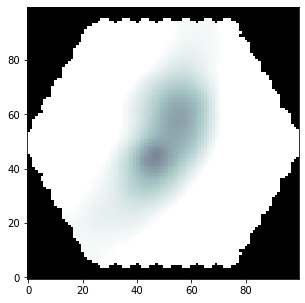

In [39]:
from copy import copy
from matplotlib import cm
cmap = copy(cm.bone_r)
cmap.set_bad('black')

fig,ax = plt.subplots(figsize=(5,5))
ax.imshow(np.log10(np.nansum(out_cube,axis=0)*(50/512)**2),vmin=4,vmax=7,origin='lower',cmap=cmap)
print(np.nansum(out_cube[150]))
print(np.nansum(data[150]))

/scratch/bottrell/Merger_Kinematics/RealSim-IFS/RealSim_IFS.py:95: RuntimeWarning: invalid value encountered in true_divide
  vbar = sum_wivi/sum_wi
/scratch/bottrell/Merger_Kinematics/RealSim-IFS/RealSim_IFS.py:96: RuntimeWarning: invalid value encountered in greater
  Nprime = np.nansum(losvd_data>0,axis=-1)
/scratch/bottrell/Merger_Kinematics/RealSim-IFS/RealSim_IFS.py:98: RuntimeWarning: divide by zero encountered in true_divide
  vstd /= (Nprime-1)/Nprime*sum_wi
/scratch/bottrell/Merger_Kinematics/RealSim-IFS/RealSim_IFS.py:98: RuntimeWarning: invalid value encountered in multiply
  vstd /= (Nprime-1)/Nprime*sum_wi
/scratch/bottrell/Merger_Kinematics/Venv/p37/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


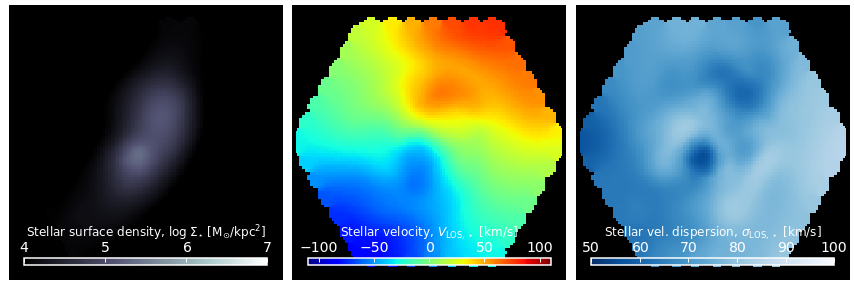

In [40]:
maps = RealSim_IFS.Generate_Maps_From_Data(filename,out_cube)

fig,axarr = plt.subplots(1,3,figsize=(15,5))
fig.subplots_adjust(wspace=0.05,hspace=0.05)
axarr = axarr.flat

for ax in axarr:
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    for spine in ['top','left','right','bottom']:
        ax.spines[spine].set_linewidth(4)

ax = axarr[0]
cmap = copy(plt.cm.bone)
cmap.set_bad('black', 1.0)
im = ax.imshow(np.log10(maps[0]*(50./512)**2),vmin=4,vmax=7,cmap=cmap,origin='lower',aspect='auto',interpolation=None)
cbar_colour = 'white'
label = r'Stellar surface density, $\log\;\Sigma_{\star}$ [M$_{\odot}}$/kpc$^2$]'
add_colorbar(im,ax,label,colour=cbar_colour)

# fov_kpc = hdr['FOV_KPC']
# kpc_per_pixel = fov_kpc/maps.shape[1]
# scale_kpc = 10
# scale_pixels = scale_kpc/kpc_per_pixel
# ax.plot([12,scale_pixels+12],[500,500],lw=2,color='white')
# ax.text(10,490,r'10 kpc',transform=ax.transData,ha='left',va='top',color='white',size=12)

ax = axarr[1]
cmap = copy(plt.cm.jet)
cmap.set_bad('black', 1.0)
im = ax.imshow(maps[1],vmin=-110,vmax=110,cmap=cmap,origin='lower',aspect='auto',interpolation='none')
cbar_colour = 'white'
label = r'Stellar velocity, $V_{\mathrm{LOS},\star}$ [km/s]'
add_colorbar(im,ax,label,colour=cbar_colour)

ax = axarr[2]
cmap = copy(plt.cm.Blues_r)
cmap.set_bad('black', 1.0)
im = ax.imshow(maps[2],vmin=50,vmax=100,cmap=cmap,origin='lower',aspect='auto',interpolation=None)
cbar_colour = 'white'
label = r'Stellar vel. dispersion, $\sigma_{\mathrm{LOS},\star}$ [km/s]'
add_colorbar(im,ax,label,colour=cbar_colour)

fig.savefig('/home/bottrell/scratch/Merger_Kinematics/RealSim-IFS/Figures/MaNGAfied_TNG_Kinematics_Test.pdf',bbox_inches='tight')

In [44]:
print(np.nansum(maps[0]))
print(np.nansum(data))

12316233478.731728
13473614379.32026


LOSVD file not found


TypeError: 'NoneType' object is not subscriptable

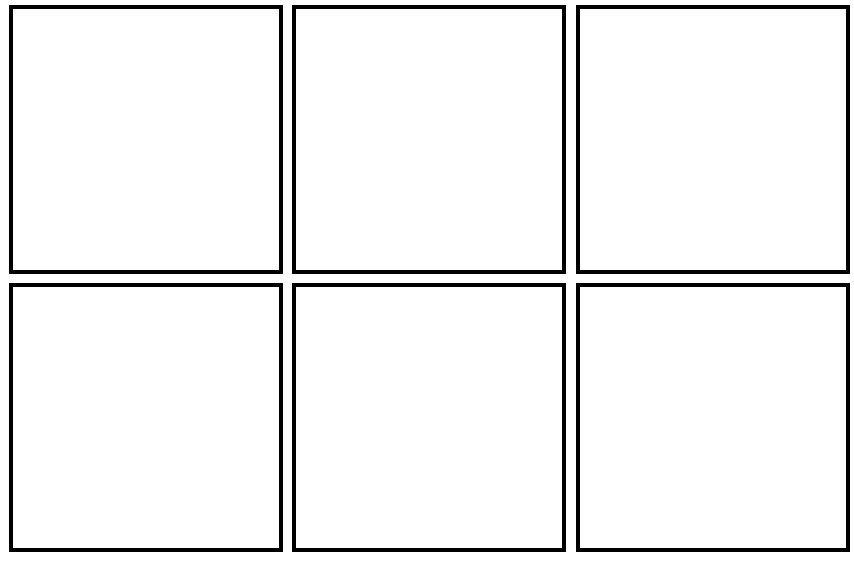

In [33]:


def add_colorbar(im,ax,label,colour='white'):
    axin = ax.inset_axes(
            [0.05,0.05, 0.9, 0.025], transform=ax.transAxes)
    cbar = plt.colorbar(im, cax=axin, orientation='horizontal')
    cbar.ax.tick_params(color=colour, labelcolor=colour,direction='in',labeltop=1,
                        labelbottom=0,top=1,bottom=0, width=1, labelsize=14)
    cbar.set_label(label, color=colour, size=12)
    cbar.ax.xaxis.set_label_position('top') 
    cbar.outline.set_edgecolor(colour)
    cbar.outline.set_linewidth(1.5)

def generate_maps(losvd_name):
    if not os.access(losvd_name,0):
        print('LOSVD file not found')
    else:
        losvd_head = fits.getheader(losvd_name)
        losvd_data = fits.getdata(losvd_name)
        losvd_shape = losvd_data.shape
        vlim = losvd_head['VLIM'] # km/s
        delv = losvd_head['DELV'] # km/s
        fov = losvd_head['FOVSIZE']/1000. # kpc
        vel = np.linspace(-vlim,vlim,losvd_shape[-1],endpoint=False)+delv/2.
        sum_wi = np.nansum(losvd_data,axis=-1)
        sum_wivi = np.nansum(losvd_data*vel,axis=-1)
        vbar = sum_wivi/sum_wi
        Nprime = np.nansum(losvd_data>0,axis=-1)
        vstd = np.nansum(losvd_data*(vel-vbar[...,np.newaxis])**2,axis=-1)
        vstd /= (Nprime-1)/Nprime*sum_wi
        vstd = np.sqrt(vstd)
        losvd_maps = np.array([sum_wi,vbar,vstd])
        return losvd_maps

def generate_figure(sim_tag,sub_tag,camera,snapID):
    
    data_dir = '/home/bottrell/scratch/Fire_Kinematics/LOSVD'
    
    fig,axarr = plt.subplots(2,3,figsize=(15,10))
    fig.subplots_adjust(wspace=0.05,hspace=0.05)
    axarr = axarr.flat

    for ax in axarr:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        for spine in ['top','left','right','bottom']:
            ax.spines[spine].set_linewidth(4)

    ptype = 'gas'
    losvd_name = '{}/{}/{}/kinemetry_datacube_{}-{}_{:04d}_{}_{}.fits'.format(data_dir,sim_tag,sub_tag,sim_tag,sub_tag,snapID,ptype,camera)
    maps = generate_maps(losvd_name)

    ax = axarr[0]
    cmap = copy(plt.cm.inferno)
    cmap.set_bad('black', 1.0)
    im = ax.imshow(np.log10(maps[0]),vmin=3,vmax=7,cmap=cmap,origin='lower',aspect='auto',interpolation=None)
    cbar_colour = 'white'
    label = r'Gas surface density, $\log\;\Sigma_{\mathrm{gas}}$ [M$_{\odot}}$/kpc$^2$]'
    add_colorbar(im,ax,label,colour=cbar_colour)

    ax = axarr[1]
    cmap = copy(plt.cm.jet)
    cmap.set_bad('black', 1.0)
    im = ax.imshow(maps[1],vmin=-150,vmax=150,cmap=cmap,origin='lower',aspect='auto',interpolation='none')
    cbar_colour = 'white'
    label = r'Gas velocity, $V_{\mathrm{LOS,gas}}$ [km/s]'
    add_colorbar(im,ax,label,colour=cbar_colour)

    ax = axarr[2]
    cmap = copy(plt.cm.Blues_r)
    cmap.set_bad('black', 1.0)
    im = ax.imshow(maps[2],vmin=0,vmax=150,cmap=cmap,origin='lower',aspect='auto',interpolation=None)
    cbar_colour = 'white'
    label = r'Gas vel. dispersion, $\sigma_{\mathrm{LOS,gas}}$ [km/s]'
    add_colorbar(im,ax,label,colour=cbar_colour)

    ptype = 'stars'
    losvd_name = '{}/{}/{}/kinemetry_datacube_{}-{}_{:04d}_{}_{}.fits'.format(data_dir,sim_tag,sub_tag,sim_tag,sub_tag,snapID,ptype,camera)
    maps = generate_maps(losvd_name)
    mask = np.log10(maps[0])<4

    ax = axarr[3]
    cmap = copy(plt.cm.bone)
    cmap.set_bad('black', 1.0)
    im = ax.imshow(np.log10(maps[0]),vmin=3,vmax=7,cmap=cmap,origin='lower',aspect='auto',interpolation=None)
    cbar_colour = 'white'
    label = r'Stellar surface density, $\log\;\Sigma_{\star}$ [M$_{\odot}}$/kpc$^2$]'
    add_colorbar(im,ax,label,colour=cbar_colour)

    maps[:,mask] = np.nan

    ax = axarr[4]
    cmap = copy(plt.cm.jet)
    cmap.set_bad('black', 1.0)
    im = ax.imshow(maps[1],vmin=-100,vmax=100,cmap=cmap,origin='lower',aspect='auto',interpolation=None)
    cbar_colour = 'white'
    label = r'Stellar velocity, $V_{\mathrm{LOS,\star}}$ [km/s]'
    add_colorbar(im,ax,label,colour=cbar_colour)

    ax = axarr[5]
    cmap = copy(plt.cm.Blues_r)
    cmap.set_bad('black', 1.0)
    im = ax.imshow(maps[2],vmin=0,vmax=150,cmap=cmap,origin='lower',aspect='auto',interpolation=None)
    cbar_colour = 'white'
    label = r'Stellar vel. dispersion, $\sigma_{\mathrm{LOS,\star}}$ [km/s]'
    add_colorbar(im,ax,label,colour=cbar_colour)
    
    return fig

sim_tag = 'G2G3_e'
sub_tag = 'orbit_1'
camera = 'i0'
snapID = 279

fig = generate_figure(sim_tag,sub_tag,camera,snapID)

# save_dir = '/home/bottrell/scratch/Fire_Kinematics/Figures/Movies'
# fig.savefig('{}/Diagnostic_{}_{}_{:04d}_{}_LowRes.png'.format(save_dir,sim_tag,sub_tag,snapID,camera),
#             bbox_inches='tight',dpi=128)